# Goal: Classify Genetic Variations using Text from Clinical Evidence
A team at Memorial Sloan Kettering Cancer Center (MSKCC) spends countless hours every year manually reviewing evidence to classify genetic mutations. Once the most important variants have been identified new therapies can be developed. Having a machine learning algorithm to automatically classify genetic variations would allow the development of therapies much sooner. This competition is a challenge to develop classification models which analyze abstracts of medical articles and, based on their content accurately determine mutation effect (9 classes) of the genes discussed in them. For more information, please refer to the Kaggle competition: https://www.kaggle.com/c/msk-redefining-cancer-treatment#description. 

Here is an article that also gives context to a project such as this and the impact could have: https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#12aad9136b25. 

This task is complex and hard to elvaluate the cross val score due to the data only representing some of the genes in the dataset. In the end, if my score is not great, I hope to have been able to better understand the use of machine learning in genomic analysis and explore its limitations. 


Also, there was a 2nd phase to this competition due to the labels for the test data being released by a third party before the competition closed. I may want to combine the training data from both phases to train the model if I am not able to get a good score from just the initial data set. 

#### Target: 9 classes that represent different levels of whether or not the variant is a driver or passenger mutation.
These are the class labels from OncoKB, but using this text in the competition is prohibited. 
1. Likely Loss-of-function
2. Likely Gain-of-function
3. Neutral
4. Loss-of-function
5. Likely Neutral
6. Inconclusive
7. Gain-of-function
8. Likely Switch-of-function
9. Switch-of-function

Using COSMIC and Genotype-Phenotype associations are not allowed due to the point of this project being modeling text.

You are not allowed to use conservation scores, or predictors of deleterious or tolerated mutations (such as Polyphen) because these tools also try to predict the effect of a mutation (which is very close to the goal of this competition) but they don't use text to do it

##### Outside resources that have been approved by kaggle for use in this competition but not necessary:
 -  Gene–disease associations: http://ctdbase.org/
 -  Text data from:
    - Encyclopedia_of_Molecular_Cell_Biology_and_Molecular_Medicine_16_volumes_Wiley_2006_
    - Cell-Molecular-Biology-Concepts-Experiments 7th edition
 - MESH topics, as well as extended information about those articles
 - Pre-trained Bio-NER taggers (May need to map the variations to RSIDs and search related articles in PubMed or PMC):
    - tmVar https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/tmvar/
    - TaggerOne https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/taggerone/
    - GNormPlus https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/gnormplus/
 - Pathway and protein information of each gene (e.g. GO).
 - Pubmed dictionaries of genes names.
 - Mygene api (http://docs.mygene.info/en/v3/doc/data.html) It contains a lot of information about genes (such as family, overall description, etc). 
 - Gene expression from The Human Protein Atlas project ( https://www.ebi.ac.uk/gxa/experiments/E-PROT-3/Downloads )
 - The aminoacid sequences for the genes in the dataset, in FASTA.
 - Other papers from PubMed in addition to the training_text in order to pre-train NLP model
 - Genia, an annotated treebank for parsing biomed papers(http://www.geniaproject.org/)
 - You can use variations themselves as features. For example a 'Deletion' in a gene may be more likely to be 1. Similar case could be made for amino acid changes. Some amino acid changes are more deleterious than others.
 - Google's trained Word2Vec models and pretrained models from bio.nlplab.org
 - Sequence data, mutation positition data and protein structure data from Uniport
 - allele frequency information from gnomAD or ExAC
 - controlled vocabularies to guide Named Entity Recognition modles. Examples: such as ICD, SNOMED CT,NCI Thesaurus, CPT, MedDRA, SNOMED CT
 
 Note from Kaggle: "We knew the task was very difficult, so Iker from MSK suggested that we allow external data, in case anyone wants to build a knowledge base for gene mutations."

---
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, \
HashingVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.corpus import stopwords

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
train_var = pd.read_csv('Data/training_variants.zip')
train_txt = pd.read_csv('Data/training_text.zip', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_var = pd.read_csv('Data/test_variants.zip')
test_txt = pd.read_csv('Data/test_text.zip', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

---
# EDA

---
### Training Variants

In [3]:
print(train_var.shape)
print(train_var.dtypes)
print(train_var.isnull().sum())
train_var.head()

(3321, 4)
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object
ID           0
Gene         0
Variation    0
Class        0
dtype: int64


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
pd.DataFrame(train_var['Gene'].value_counts())

,Gene
BRCA1,264
TP53,163
EGFR,141
PTEN,126
BRCA2,125
KIT,99
BRAF,93
ALK,69
ERBB2,69
PDGFRA,60


In [5]:
pd.DataFrame(train_var['Variation'].value_counts())

,Variation
Truncating Mutations,93
Deletion,74
Amplification,71
Fusions,34
Overexpression,6
G12V,4
Q61L,3
Q61H,3
E17K,3
Q61R,3


In [6]:
train_var['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

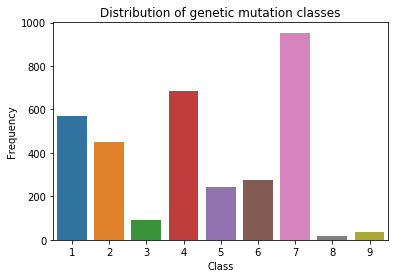

In [7]:
plt.figure()
sns.countplot(x="Class", data=train_var)
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title("Distribution of genetic mutation classes")
plt.show()

##### Looking at the genes with 50 or more occurances in the training data set

In [8]:
# BRCA1
BRCA1 = train_var.loc[train_var['Gene']=='BRCA1']
print(BRCA1['Class'].value_counts())

5    90
1    60
6    53
4    46
3    15
Name: Class, dtype: int64


In [9]:
# TP53
TP53 = train_var.loc[train_var['Gene']=='TP53']
print(TP53['Class'].value_counts())

1    83
4    67
6     5
2     3
5     2
3     2
9     1
Name: Class, dtype: int64


In [10]:
# EGFR
EGFR = train_var.loc[train_var['Gene']=='EGFR']
print(EGFR['Class'].value_counts())

7    84
2    45
4     5
5     3
8     1
6     1
3     1
1     1
Name: Class, dtype: int64


In [11]:
# PTEN
PTEN = train_var.loc[train_var['Gene']=='PTEN']
print(PTEN['Class'].value_counts())

4    115
3      5
1      3
5      2
7      1
Name: Class, dtype: int64


In [12]:
# BRCA2
BRCA2 = train_var.loc[train_var['Gene']=='BRCA2']
print(BRCA2['Class'].value_counts())

6    84
5    20
1    18
4     3
Name: Class, dtype: int64


In [13]:
# KIT
KIT = train_var.loc[train_var['Gene']=='KIT']
print(KIT['Class'].value_counts())

7    52
2    44
6     1
4     1
3     1
Name: Class, dtype: int64


In [14]:
# BRAF
BRAF = train_var.loc[train_var['Gene']=='BRAF']
print(BRAF['Class'].value_counts())

7    48
2    31
5     8
6     3
4     2
3     1
Name: Class, dtype: int64


In [15]:
# ERBB2
ERBB2 = train_var.loc[train_var['Gene']=='ERBB2']
print(ERBB2['Class'].value_counts())

7    30
2    14
6    12
5     6
4     5
8     1
1     1
Name: Class, dtype: int64


In [16]:
# ALK
ALK = train_var.loc[train_var['Gene']=='ALK']
print(ALK['Class'].value_counts())

7    47
3    10
2     7
5     5
Name: Class, dtype: int64


In [17]:
# PDGFRA
PDGFRA = train_var.loc[train_var['Gene']=='PDGFRA']
print(PDGFRA['Class'].value_counts())

7    42
3     9
5     4
2     3
4     1
1     1
Name: Class, dtype: int64


In [18]:
# PIK3CA
PIK3CA = train_var.loc[train_var['Gene']=='PIK3CA']
print(PIK3CA['Class'].value_counts())

7    31
2    14
5     8
6     3
Name: Class, dtype: int64


In [19]:
# CDKN2A
CDKN2A = train_var.loc[train_var['Gene']=='CDKN2A']
print(CDKN2A['Class'].value_counts())

4    47
1     4
6     1
Name: Class, dtype: int64


In [20]:
# FGFR2
FGFR2 = train_var.loc[train_var['Gene']=='FGFR2']
print(FGFR2['Class'].value_counts())

7    27
2     7
1     7
5     5
6     4
Name: Class, dtype: int64


---
### Training Text

In [21]:
print(train_txt.shape)
print(train_txt.isnull().sum())
train_txt.head()

(3321, 2)
ID      0
Text    5
dtype: int64


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


---
### Test Variants

In [22]:
print(test_var.shape)
test_var.head()

(5668, 3)


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [23]:
print(test_var.dtypes)
print(test_var.isnull().sum())

ID            int64
Gene         object
Variation    object
dtype: object
ID           0
Gene         0
Variation    0
dtype: int64


---
### Test Text

In [24]:
print(test_txt.shape)
test_txt.head()

(5668, 2)


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [25]:
print(test_txt.dtypes)
print(test_txt.isnull().sum())

ID       int64
Text    object
dtype: object
ID      0
Text    1
dtype: int64


---
Merge Test text and var dataframes

In [3]:
df_test = test_var.merge(test_txt, on='ID')

Drop null columns

In [4]:
df_test.isnull().sum()

ID           0
Gene         0
Variation    0
Text         1
dtype: int64

In [5]:
df_test.dropna(inplace=True)

In [6]:
df_test.isnull().sum() # shows that null value was dropped

ID           0
Gene         0
Variation    0
Text         0
dtype: int64

# Preprocessing


Joining variant and text training dataframes, drop null rows, and then split into X and y. Will need to get dummies to create a sparse matrix for a multiclass target. 

In [7]:
df = train_var.merge(train_txt, on='ID')

In [8]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum() # shows that null value was dropped

ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64

In [11]:
X = df[['Gene', 'Variation', 'Text']]
# X = pd.get_dummies(X, prefix=['gene', 'var'], prefix_sep='', columns=['Gene', 'Variation'])
X.head()

,Gene,Variation,Text
0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [12]:
y = df['Class']
print(y.shape)
# y = pd.get_dummies(y, prefix='class', prefix_sep='', columns=['Class'])
y.head()

(3316,)


0    1
1    2
2    2
3    3
4    4
Name: Class, dtype: int64

Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [43]:
print('Shapes', '\n'
      'X:',X.shape,'\n'
      'y:',y.shape,'\n'
      'X_train:',X_train.shape, '\n'
      'X_test:',X_test.shape,'\n' 
      'y_train:',y_train.shape,'\n' 
      'y_test:',y_test.shape
)

Shapes 
X: (3316, 3) 
y: (3316,) 
X_train: (2221, 3) 
X_test: (1095, 3) 
y_train: (2221,) 
y_test: (1095,)


In [15]:
X_train.head()

,Gene,Variation,Text
2660,BRCA1,E1250K,Mutations in BRCA1 and BRCA2 account for the m...
2368,PTPN11,Deletion,"PTPN11, which encodes tyrosine phosphatase Shp..."
1917,SMO,D473G,The Hedgehog (Hh) signaling pathway is inappro...
2207,PTEN,F341V,We screened mutations of two major tumor suppr...
262,EGFR,E746_S752delinsA,Non–small-cell lung cancer is the leading caus...


# Modeling


#### Defining classes

In [16]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Accepts a single column and returns the column as a numpy array.
    """
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column]

In [17]:
class CategoricalExtractor(BaseEstimator, TransformerMixin):
    """
    One-hot-encodes a categorical (string) column.
    """
    def __init__(self, column):
        self.column = column
        self.values = None
        
    def _create_values(self, indices):
        return {ind: i+1 for i, ind in enumerate(indices)}
    
    def _apply_values(self, row_val):
        return self.values.get(row_val, 0)
        
    def fit(self, X, y=None):
        self.values = self._create_values(X[self.column].value_counts().index)
        return self 
    
    def transform(self, X, y=None):
        col = X[self.column].apply(self._apply_values)
        return col.values.reshape(-1, 1)

#### Making pipelines

In [18]:
# text_pipe = make_pipeline(
#     FeatureExtractor('Text'),
#     CountVectorizer(stop_words='english'),
#     FunctionTransformer(lambda x: x.todense(), accept_sparse=True) # Takes the sparse matrix that CountVectorizer 
# )                                                                  # spits out and changes it back into a dense 
#                                                                    # matrix for the feature union.
# gene_pipe = make_pipeline(
#     FeatureExtractor('Gene'),
#     CategoricalExtractor('Gene'),
#     FunctionTransformer(lambda x: x.reshape(-1, 1)) # Takes the data coming out of FeatureExtractor (which is shape
# )                                                   # (nrows, ) and changes it to be shape (nrows, 1)) which we 
#                                                     # need for the feature union.

# var_pipe = make_pipeline(
#     FeatureExtractor('Variation'), 
#     CategoricalExtractor('Variation'),
#     FunctionTransformer(lambda x: x.reshape(-1, 1))
# )

# fu = make_union(text_pipe, gene_pipe, var_pipe)

# model_pipe = make_pipeline(
#     fu,
#     RandomForestClassifier()
# )

text_pipe = make_pipeline(
FeatureExtractor('Text'),
CountVectorizer(stop_words='english'),
FunctionTransformer(lambda x: x.todense(), accept_sparse=True)
)

gene_pipe = make_pipeline(
CategoricalExtractor('Gene'),
OneHotEncoder(sparse=False, handle_unknown='ignore')
)

var_pipe = make_pipeline(
CategoricalExtractor('Variation'),
OneHotEncoder(sparse=False, handle_unknown='ignore')
)

fu = make_union(text_pipe, gene_pipe, var_pipe)

model_pipe = make_pipeline(
fu,
OneVsRestClassifier(estimator=SVC(probability=True))
)

#### Fitting model on only part of the data

In [43]:
model_pipe.fit(X_train[:200], y_train[:200])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column='Text')), ('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'...bability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1))])

In [45]:
print(model_pipe.score(X_train[:200], y_train[:200]))

0.98


In [47]:
model_pipe.predict_proba(X_train[:200])

array([[ 0.06674076,  0.07898648,  0.01776453, ...,  0.09354263,
         0.02024547,  0.00591952],
       [ 0.11715547,  0.13860081,  0.03115709, ...,  0.16407703,
         0.03568844,  0.01363267],
       [ 0.10497413,  0.49519038,  0.02793387, ...,  0.14716771,
         0.0321212 ,  0.01239527],
       ..., 
       [ 0.08736103,  0.57987527,  0.02255858, ...,  0.12242479,
         0.02671937,  0.00768929],
       [ 0.08496009,  0.58979179,  0.02261483, ...,  0.11905934,
         0.02592807,  0.00747984],
       [ 0.61024956,  0.09214324,  0.02069834, ...,  0.10897716,
         0.02359913,  0.0068488 ]])

In [49]:
model_pipe.predict_proba(X_train[:200])[1].sum()

1.0

In [50]:
print(model_pipe.score(X_test[:200], y_test[:200]))

0.45


#### Fitting the model on the entire train dataset

In [51]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column='Text')), ('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'...bability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1))])

In [52]:
print(model_pipe.score(X_train, y_train))

0.83881134624


In [53]:
print(model_pipe.score(X_test, y_test))

0.611872146119


#### This was a first pass score

In [240]:
# Random forest classifier
# print(model_pipe.score(X_train, y_train))

0.982440342188


## Neral Nets with Keras

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

Using TensorFlow backend.


In [88]:
# Created new text_pipe to cut down on the number of features inputed in the neural net due to memory error.
# There were 41028 features coming out of the CountVectorizer.

text_pipe_k = make_pipeline(
# FeatureExtractor('Text'),
FunctionTransformer(lambda df: df['Text'], validate=False), 
CountVectorizer(stop_words='english'),
TruncatedSVD(n_components=5000)
# FunctionTransformer(lambda x: x.reshape(-1, 1)),
# FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=False)
)

fu = make_union(text_pipe_k, gene_pipe, var_pipe)

In [89]:
# Function to create model, required for KerasClassifier
def create_model(input_dim=30):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5, seed=42)) # 50% dropout with 42 random state
    model.add(Dense(9, activation='softmax')) # Activation function for the final output layer 
                                                             # needs to be softmax to accomidate the nine 
                                                             # different classes.

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:
# def printX(X):
#     print(X.shape)
#     return X

In [91]:
# model_pipe_keras = make_pipeline(fu,
# #                                  FunctionTransformer(printX),
#                                  KerasClassifier(build_fn=create_model, input_dim=312, epochs=2, batch_size=10, verbose=1)
#                                 )

Allows the number of features to be input automatically.

In [ ]:
X_train_ap = fu.fit_transform(X_train)

In [ ]:
model_keras = KerasClassifier(build_fn=create_model, input_dim=X_train_ap.shape[1], epochs=10, batch_size=10, verbose=1)

In [ ]:
model_keras.fit(X_train_ap, y_train.values) # .values: pd df to numpy matrix

Score of test of test train split

In [80]:
model_keras.predict_proba(fu.transform(X_test))

1095/1095 [==============================] - 0s 313us/step


array([[  1.59491614e-01,   2.19694793e-01,   5.76639809e-02, ...,
          1.25669599e-01,   2.95009073e-02,   8.57762843e-02],
       [  2.23048404e-02,   1.77942496e-03,   7.50496387e-01, ...,
          1.23288624e-01,   3.65310395e-03,   5.86872120e-05],
       [  9.32567709e-05,   1.82996877e-02,   1.65729113e-02, ...,
          9.58231330e-01,   1.29706677e-04,   5.35025247e-05],
       ..., 
       [  2.31455397e-02,   5.56576587e-02,   1.42178787e-05, ...,
          9.10925865e-01,   6.26178226e-03,   3.79859994e-05],
       [  3.11045554e-08,   6.62461556e-16,   4.79166290e-11, ...,
          2.34269646e-16,   4.88801662e-18,   4.04895186e-27],
       [  4.17267710e-01,   1.83150098e-02,   1.79649413e-01, ...,
          5.88812083e-02,   4.82242496e-04,   6.10550679e-03]], dtype=float32)

In [81]:
model_keras.score(fu.transform(X_test), y_test)

1095/1095 [==============================] - 0s 405us/step


0.59086758333798417

Score of test.csv

In [65]:
model_keras.predict_proba(fu.transform(df_test))

5667/5667 [==============================] - 1s 233us/step


array([[  1.94211595e-03,   5.39127961e-02,   1.04125720e-05, ...,
          9.41870451e-01,   8.22879738e-05,   6.96811621e-05],
       [  1.90934613e-01,   1.23797536e-01,   9.14123580e-02, ...,
          6.66483790e-02,   2.22278889e-02,   3.98748778e-02],
       [  2.18555533e-06,   9.86302257e-06,   3.13638289e-08, ...,
          9.99973536e-01,   6.75220857e-09,   5.82818025e-08],
       ..., 
       [  7.37759611e-03,   3.76747876e-01,   9.88245301e-06, ...,
          6.06603563e-01,   3.03657464e-04,   2.30663922e-03],
       [  7.76658803e-02,   4.78446931e-02,   6.24088794e-02, ...,
          7.10803151e-01,   3.53051047e-03,   2.93173990e-03],
       [  3.77911210e-01,   1.54853165e-02,   4.90666814e-02, ...,
          4.71451432e-02,   1.33920405e-02,   2.13235188e-02]], dtype=float32)

In [74]:
# Downloading target answers to test.csv

# df_test_target = pd.read_csv('Data/stage1_solution_filtered.csv.7z', compression='gzip', header=0, sep=',', quotechar='"')



import libarchive.public

with open('Data/stage1_solution_filtered.csv.7z', 'rb') as f:
    buffer_ = f.read()
    with libarchive.public.memory_reader(buffer_) as e:
        for entry in e:
            with open('/tmp/' + str(entry), 'wb') as f:
                for block in entry.get_blocks():
                    f.write(block)

OSError: Not a gzipped file (b'7z')

In [ ]:
model_keras.score(fu.transform(_test), y_test)

BASELINE

In [61]:
y_train.value_counts().max()/y_train.value_counts().sum()

0.28725799189554257

Got model to work, but above code allows the number of features to be input automatically.

In [104]:
model_pipe_keras.fit(X_train[:200], y_train[:200].values)

Epoch 1/2
200/200 [==============================] - 0s 2ms/step - loss: 11.9615 - acc: 0.1400
Epoch 2/2
200/200 [==============================] - 0s 1ms/step - loss: 10.2135 - acc: 0.2250


Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x14a17d158>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pa...ts=None)), ('kerasclassifier', <keras.wrappers.scikit_learn.KerasClassifier object at 0x1489150f0>)])

This needs to be deleted and was the process to get to the working pipeline.

In [53]:
# allows naming of the unions (and weighting of transformers), takes a list of tuples
combine_features_union = FeatureUnion([
#     ('cvec',CountVectorizer(['Text'])),
    ('gene', CategoricalExtractor('Gene')),
    ('var', FeatureExtractor('Variation'))
])

NameError: name 'FeatureExtractor' is not defined

In [135]:
pipe = Pipeline([
    ('cfu', combine_features_union),
    ('cvec',TfidfVectorizer(stop_words='english')),
    ('clf_gs',OneVsRestClassifier(estimator=SVC(random_state=0)))]) #SVC(kernel='linear').set_params(probability=True)))])

# grid ={'cvec':[CountVectorizer(), TfidfVectorizer()],
#     'cvec__stop_words': [None, 'english'],
#     'clf_gs':[OneVsRestClassifier(estimator=SVC(random_state=0))]}

# pipe_gs = GridSearchCV(pipe, param_grid=grid)

# ----------------------------------------------------------------------------

# pipeGS = Pipeline([
#     ('cfu', combine_features_union),
#     ('ss', StandardScaler()),
#     ('clf_gs', GridSearchCV(RandomForestClassifier(),param_grid={}))
# ])

# # define the grid search that controls the named pipeline objects
# grid = {
#     # clean up the ss
#     'ss':[StandardScaler()],
#     'clf_gs':[GridSearchCV(KNeighborsClassifier(),
#                          param_grid={'n_neighbors':[3,6,9]}),
#             GridSearchCV(RandomForestClassifier(),
#                          param_grid={'n_estimators':np.arange(20,120,20),
#                                      'max_depth':np.arange(5,30,5)})
#            ]
# }

# # create grid search object with above grid searching parameters and fit
# gs = GridSearchCV(pipeGS,param_grid=grid)
# gs.fit(X_train,y_train)

In [136]:
pipe.steps

[('cfu', FeatureUnion(n_jobs=1,
         transformer_list=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input=['Text'],
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)), ('gene', CategoricalExtractor(column='Gene')), ('var', FeatureExtractor(column='Variation'))],
         transformer_weights=None)),
 ('cvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words='english', strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b',

Fit the best model params to the training data

In [137]:
pipe.fit(X_train[], y_train)

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 2225, expected 3.

In [40]:
# # Processing text
# vec = CountVectorizer(stop_words='english')
# vec.fit(X_train)
# X_tfidf = vec.transform(X_train)
# X_tfidf

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [43]:
# # Just trying to get a rough model working

# OvR = OneVsRestClassifier(SVC(kernel='linear').set_params(probability=True))
# OvR.fit(X_tfidf, y_train)
# # OvR

Trying modeling only using text in X

In [3]:
df = train_var.merge(train_txt ,on='ID')
X = df[[ 'Text']]
X.head()

,Text
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
y = df['Class']
y = pd.get_dummies(y, prefix='class', prefix_sep='', columns=['Class'])
y.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.95, random_state=42)


print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(166, 1) (3155, 1) (166, 9) (3155, 9)


In [18]:
CountVectorizer(['Text']).fit_transform(X_train).shape

(1, 1)

In [15]:
pd.DataFrame(CountVectorizer().fit_transform(X_train['Text']).todense()).head(2)

,0,1,2,3,4,5,6,7,8,9,...,38660,38661,38662,38663,38664,38665,38666,38667,38668,38669
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('clf_gs',OneVsRestClassifier(estimator=SVC(random_state=0)))]) #SVC(kernel='linear').set_params(probability=True)))])

# grid ={'cvec':[CountVectorizer(), TfidfVectorizer()],
#     'cvec__stop_words': [None, 'english'],
#     'clf_gs':[OneVsRestClassifier(estimator=SVC(random_state=0))]}

# pipe_gs = GridSearchCV(pipe, param_grid=grid)

In [16]:
pipe.steps

[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('clf_gs',
  OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True,
    tol=0.001, verbose=False),
            n_jobs=1))]

[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),


In [19]:
X_train.head()

,Text
993,Tuberous sclerosis complex (TSC) is an autosom...
2308,Summary Hepatocellular adenomas (HCA) are beni...
688,Cell division is controlled by a series of pos...
246,Purpose: Epidermal growth factor receptor (EGF...
1512,EML4–ALK fusions define a subset of lung cance...


In [20]:
y_train.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
993,0,0,0,1,0,0,0,0,0
2308,0,0,0,0,0,0,1,0,0
688,0,0,0,1,0,0,0,0,0
246,0,0,0,0,0,0,1,0,0
1512,0,1,0,0,0,0,0,0,0


In [21]:
pipe.fit(X_train['Text'], y_train)

/Users/Hallie/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


Pipeline(steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...robability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1))])